In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
img_folder='/content/drive/MyDrive/sprints project /Scenes training set'
import splitfolders
splitfolders.ratio(img_folder, output="output",
    seed=1337, ratio=(.7,0.3), group_prefix=None, move=False)

Copying files: 14034 files [05:14, 44.58 files/s] 


In [4]:
train_dir = '/content/output/train'
val_dir = '/content/output/val'
test_dir = '/content/drive/MyDrive/sprints project /testset/Scenes testing test'

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [6]:
from keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
 
val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
 
val_set = val_datagen.flow_from_directory(val_dir,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(
    directory=r'/content/drive/MyDrive/sprints project /testset',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 9820 images belonging to 6 classes.
Found 4214 images belonging to 6 classes.
Found 3050 images belonging to 1 classes.


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Activation

In [8]:
class ResUnit(keras.layers.Layer):
    def __init__(self, filters,activation="relu",strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.strides = strides
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(self.filters,(3,3),strides=self.strides, 
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(self.filters, (3,3), strides=1, 
                                padding="same", use_bias = False),
            keras.layers.BatchNormalization()]
        self.skip_layer = []        
        if strides > 1:
            self.skip_layer = [keras.layers.Conv2D(self.filters,1,
                            strides=self.strides,padding="same", use_bias=False),
                               keras.layers.BatchNormalization()
                              ]
    def call(self,inputs):
        x = inputs
        for layer in self.main_layers:
            x = layer(x)
        skip_input = inputs
        for layer in self.skip_layer:
            skip_input = layer(skip_input)
        return self.activation(x + skip_input)
    def get_config(self):
        base_config= super().get_config()
        return {**base_config, 
                "filters": self.filters, 
                "activation":self.activation,
                "strides": self.strides
               }

In [9]:
def getModel_ResNet34(layer_activation="relu", 
                 input_shape=(32,32,3),
                 output_dim=6,
                 out_activation="softmax"):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape= input_shape))
    model.add(keras.layers.Conv2D(64,7,strides=2,padding="same",use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation(layer_activation))
    model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
    prev_filter = 64
    for filters in [64]*3+[128]*4+[256]*6+[512]*3:
        strides = 1 if prev_filter == filters else 2
        model.add(ResUnit(filters, strides=strides, activation=layer_activation))
        prev_filter = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(output_dim,activation=out_activation))
    return model

In [10]:
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
def swish(x, beta=1):
    return (x * sigmoid(beta * x))

In [11]:
from keras.utils.generic_utils import get_custom_objects
get_custom_objects().update({"ResUnit": ResUnit})
get_custom_objects().update({"swish": swish})

In [12]:
learning_rate = 0.001
lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps= 100000,
    decay_rate= 0.96,
    staircase=True)

model = getModel_ResNet34(layer_activation="swish")
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_scheduler),
                    loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        9408      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                                 
 res_unit (ResUnit)          (None, 8, 8, 64)          74240     
                                                                 
 res_unit_1 (ResUnit)        (None, 8, 8, 64)          7

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

optm = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optm,  metrics=['accuracy'])

from keras.callbacks import EarlyStopping,ReduceLROnPlateau
EarlyStopping = EarlyStopping(monitor='val_accuracy',  min_delta=.01,  patience=7,verbose=1, mode='max', baseline=None,
                              restore_best_weights=True)

rlr = ReduceLROnPlateau( monitor="val_accuracy",factor=0.01,patience=3,verbose=0,mode="max", min_delta=0.01)

model_save = ModelCheckpoint('./resnet.h5', save_best_only = True,save_weights_only = False, monitor = 'val_loss', 
                             mode = 'min', verbose = 1)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
resnet_history = model.fit(training_set, steps_per_epoch = 250 , epochs = 25,
                              validation_data = val_set,callbacks=[EarlyStopping, model_save,rlr])

Epoch 1/25
250/250 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.7390
Epoch 1: val_loss improved from inf to 0.19502, saving model to ./resnet.h5
250/250 [==============================] - 140s 426ms/step - loss: 0.2569 - accuracy: 0.7390 - val_loss: 0.1950 - val_accuracy: 0.7786 - lr: 1.0000e-04
Epoch 2/25
250/250 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.7725
Epoch 2: val_loss did not improve from 0.19502
250/250 [==============================] - 105s 421ms/step - loss: 0.1839 - accuracy: 0.7725 - val_loss: 0.2291 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 3/25
250/250 [==============================] - ETA: 0s - loss: 0.1679 - accuracy: 0.7981
Epoch 3: val_loss improved from 0.19502 to 0.18089, saving model to ./resnet.h5
250/250 [==============================] - 106s 424ms/step - loss: 0.1679 - accuracy: 0.7981 - val_loss: 0.1809 - val_accuracy: 0.7779 - lr: 1.0000e-04
Epoch 4/25
250/250 [==============================] -

In [18]:
STEP_SIZE_VALID=val_set.n//val_set.batch_size
model.evaluate_generator(generator=val_set,
steps=STEP_SIZE_VALID)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.11070658266544342, 0.871421754360199]

In [19]:
STEP_SIZE_TRAIN=training_set.n//training_set.batch_size
model.evaluate_generator(generator=training_set,
steps=STEP_SIZE_TRAIN)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.10399972647428513, 0.8868464231491089]

In [22]:
import os 
import glob
import pandas as pd

Name = []

for img in glob.glob(test_dir):
    prediction = model.predict_generator(test_set,steps=3050,verbose=1)
    for name in os.listdir(test_dir):
         Name.append(name[0::])



predicted_class_indics=np.argmax(prediction,axis=1)
Name.sort()
Temp = {'Image':Name, 'Label':predicted_class_indics}
temp = pd.DataFrame(Temp)
temp.to_csv('/content/results.csv', index=False)

  11/3050 [..............................] - ETA: 36s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


3050/3050 [==============================] - 27s 9ms/step


In [23]:
temp

,Image,Label
0,1020.jpg,0
1,103.jpg,0
2,1053.jpg,0
3,1081.jpg,0
4,1082.jpg,0
...,...,...
3045,920.jpg,0
3046,949.jpg,0
3047,952.jpg,0
3048,961.jpg,0


In [24]:
pip install plot_keras_history


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 321 kB 40.1 MB/s 
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.37-py3-none-any.whl size=9408 sha256=b11cb9624fecbed56fb50dd6c235863e213499059d1ccae4faf2ecc154f4dc80
  Stored in directory: /root/.cache/pip/wheels/72/91/3c/9306e573b56b6ea00e7d37c2286d51d1f8f2d7b1b078bf3399
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.49-py3-none-any.whl size=320403 sha256=1a1827f933665d8e76aa61215e02bec9c75266dfbda2e192aa5c4cf9db60222a
  Stored in directory: /root/.cache/pip/wheels/f6/0a/7a/c00024468dd987395ee9bd54d293f6cc31f58da13dc2cfc5fc
  Created wheel for support-developer: filename=support_developer-1.0.4-py3-none-any.whl size=5067 sha256=d4a063c2b7cac73cc4697e6726e45a5412c89fac8225392ecef28b1265ceccd0
  Stored in directory: /root/.cache/pip/wheels/e7/9d/c8/1209cb780a301c5181e3da11b8b4e161d30d034c6370b995ce
 

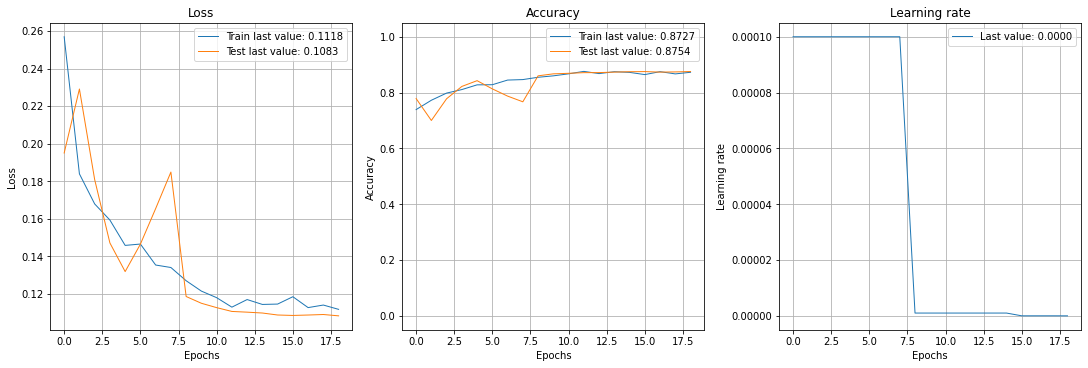

In [25]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt


show_history(resnet_history)
plot_history(resnet_history, path="standard.png")
plt.close()

